<h1 align="center">
	Further optimizations of Grover’s Search algorithm
</h1>

In [23]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.compiler import transpile
# Loading your IBM Q account(s) + hardware
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device=provider.get_backend('ibmq_16_melbourne')
# Simulator
simulator = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2020-07-07 17:13:56,138: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
from grover import * # boolean_grover()
%run phase&modified_grover.py # phase_grover()

Nowadays, one of the critical issues to implement quantum algorithms is the required number of elementary gates, qubits, and delay. Current quantum computers and simulators are mainly prototypes, and there is a lack of computational resources. Therefore, it is necessary to optimize the quantum operations to reduce the necessary number of gates and qubits. This work target the oracle and diffuser part of Grover's algorithm where I represent an optimization of them. A quantitative analysis has been performed on the number of qubits, circuit depth, number of gates.

The oracle plays an important role in Grover's circuit, where it occurs two times, one in the so called the oracle part, and the other in the diffuser part.

As we saw in previous code (the boolean_grover), we implemented the boolean oracle (BO) type for the Grover's circuit, which relies on an additional qubit to carry out the difference of phase on the state of interest. Whereas there is another type of oracle; the phase oracle (PO), this latter don't use any ancillary qubit, it dephase the target ket directly by applying a Z gate on the last qubit (multiply its amplitude by $e^{i\pi}$). Hence, the PO is better than the BO since it uses fewer qubits to run.

The next step is implementing it in the quantum circuit, to do that, the obvious thing is the multi conditioned qubits gate Fig1, but this latter, when transpiled to be run on quantum hardware, will show a high circuit depth which doesn't play in our favor, because the circuit exceeds the limits regarding the coherence time of the quantum computer currently used. So this is a reason why it would be interesting to increase that time to do like those jobs efficiently; it is a good thing to have a very long coherence time so you can fit all your gates $-$in recent quantum superconducting qubits hardware, the highest-coherence qubits fabricated today is around the 100 microseconds. On the other hand, searching for a long time is not the only interest, nowadays scientists are interested in the question of how many operations can we fit within that time? where each of those gates takes some time to apply, so it's a question of how much time do those operations take relative to the coherence time that the qubit has, thus we need to be able to apply those operations very quickly. Decreasing the circuit depth is mandatory to contribute achieving that goal.

<img src="5_noancilla.png" alt="drawing" width="200" label="figure 1"/>

Another solution rather than expanding circuit depth exponentially is to use ancilla qubit. All we need to use is multiple two-qubits Toffoli gates (`ccx`), each of them can be decomposed to 15 elementary gates, 6 CNOT gates among them, acting just only on the pair of qubits Fig2 (from Mike & Ike book)

<img src="5_ ancilla.png" alt="drawing" width="800" label="figure 2"/>


You can see how many CCNOT when we use ancilla qubit, it is cheaper nevertheless it's still extremely expensive, because increasing the number of controlled qubits will use more ancillas which is out of the scope of the hardware implementation.

This is why thinking of decreasing the number of ancillary qubits in the oracle is mandatory. Eventually, this is what I did, playing with those two-qubit Toffoli gates I figure out that the Fig2 can be implemented with 9 qubits rather than 10, hence we reduce the nubmer of qubits (we are going to see by using the phase oracle we reduce the number of qubits by 3 (2 in case of three qubits) compared with the boolean_grover code which uses the boolean oracle and the Mike & Ike $C^n(U)$ implementation) and also the depth since we are going to cancel one Toffoli gate and a the control-U (again by using the phase oracle we reduce the number of ccx by three (and two in the case of three qubits) compared with the previous file which uses the boolean oracle and the Mike & Ike $C^n(U)$ implementation).

### -The optimized Oracle:
As we can see below the number of qubits is reduced by one and this new design is applicable for n multi-qubit control gate.


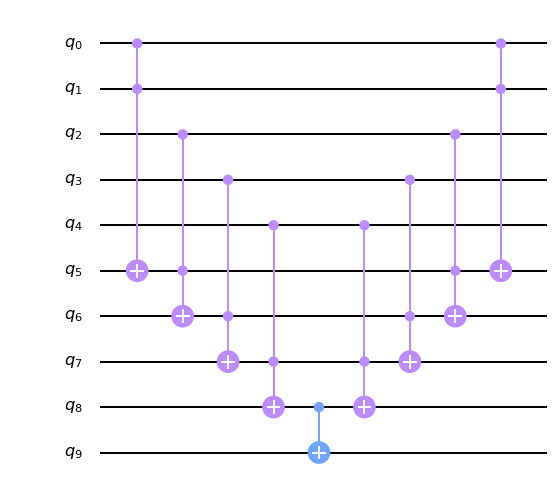

In [51]:
########################### Mike & Ike $C^n(U)$ design: n=5 qubits control gate ###########################
# ***** Target qubit is q9 *****
s0=boolean_oracle(['11111'], 'ancilla')
s0.draw('mpl')

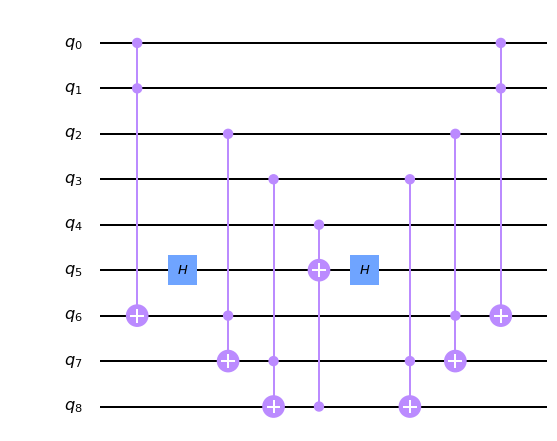

In [52]:
############################## New design n=5-qubits control gate ##############################
# ***** Target qubit is q5 *****
s=oracle(['111111'], 'ancilla')
s.draw('mpl')

In the new design implementation, ignore the two Hadamard gate (they are added because $HXH=Z$ and this concern the phase oracle), also the length of digits inside the functions of the Mike & Ike design is 4 and not 5 because I used the function boolean_grover circuit which uses one additional qubit, hence she implement 5-qubit control gate.

An exceptional case is the three control qubit where it uses two Toffoli gate rather than four following the Mike & Ike design, it is implemented as:

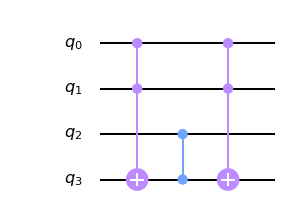

In [55]:
############################## New design 3-qubits control gate ##############################
# ***** Target qubit is q2 *****
s1=oracle(['111'], 'ancilla')
s1.draw('mpl')

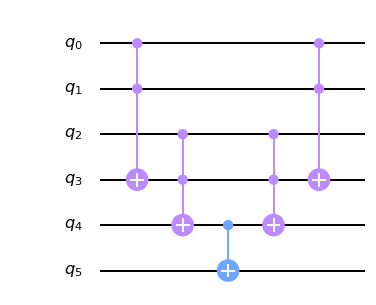

In [54]:
############################## Mike & Ike design 3-qubits control gate ##############################
# ***** Target qubit is q5 *****
s2=boolean_oracle(['111'], 'ancilla')
s2.draw('mpl')

### -The optimized diffuser
In this part there is a set of operation that realize the transition from a difference of phase (made by the oracle) to a difference of amplitude (inversion about the mean):

   1-Cancel the superposition by a layer of H gate let's calle it A

   2-Multiply the amplitude of the $|0>_n$ state by -1, this is called a mirror operation $M_0=X^{\otimes n} M_1 X^{\otimes n}$.
    
   3-Restoring the superposition by another layer of H gate called $A^\dagger$, which increases the probability of seeing the desired state.
    
The overall effect is $D=-AM_0A^\dagger$ in the standard version of Grover's algorithm $A=H$ whereas in this paper [[1](https://arxiv.org/abs/2005.06468)] they assign to it another operation; whereby their main achievement is a generalization of the inversion about the mean step, thus rather than canceling the superposition they go forward to another state that makes the reflection easier. They succeeded to combine the action of the first layer of step 1 $H^{\otimes n}$ with the first layer of step 2 $X^{\otimes n}$ into a more efficient operator B where the Grover diffuser turn into $D=B^\dagger M_B B$. They supposed an operator B such that $BA=X^{\otimes n}$, then $A^\dagger=X^{\otimes n} B$ and $A=B^\dagger X^{\otimes n}$ then the Grover diffusion becomes: $$\begin{aligned}
D &=A M_{0} A^{\dagger} \\
&=B^{\dagger} X^{\otimes n} M_{0} X^{\otimes n} B \\
&=B^{\dagger} X^{\otimes n} X^{\otimes n} M_{1} X^{\otimes n} X^{\otimes n} B \\
&=B^{\dagger} M_{1} B
\end{aligned}$$
In this case, $M_B=M_1$, which uses fewer gates than $M_0$, therefore avoid the $X$ gates on either side of the multi-control gate. The modified version of the algorithm set $B=R_x(\pi/2)$ and $B^\dagger=R_x(-\pi/2)$; in general this leads to save $2n$ X gates per mirror operation.

Hence the modification is as follow: $HX \rightarrow R_x(\pi/2)$ and $X^\dagger H^\dagger \rightarrow R_x(-\pi/2)$

The preparation layer is also replaced: $H \rightarrow R_x(\pi/2)$

And now let's do a comparison between the boolean Grover's circuit and phase+modified Grover's circuit by evaluating the circuit depth, widht and quantum cost ( this latter is done by the transpiler where it is the procedded step before running the circuit on the quantum hardware, it does 2 main things: 

1-Expresses high-level gate definitions in terms of the basis gates actually supported by the quantum hardware, in this case is the `ibmq_16_melbourne`.

2-Optimizes the code. )

### 1-Phase oracle + new design Grover's circuit evaluation:

Circuit width 5
Count of operations OrderedDict([('rx', 28), ('ccx', 18), ('h', 12), ('measure', 4)])


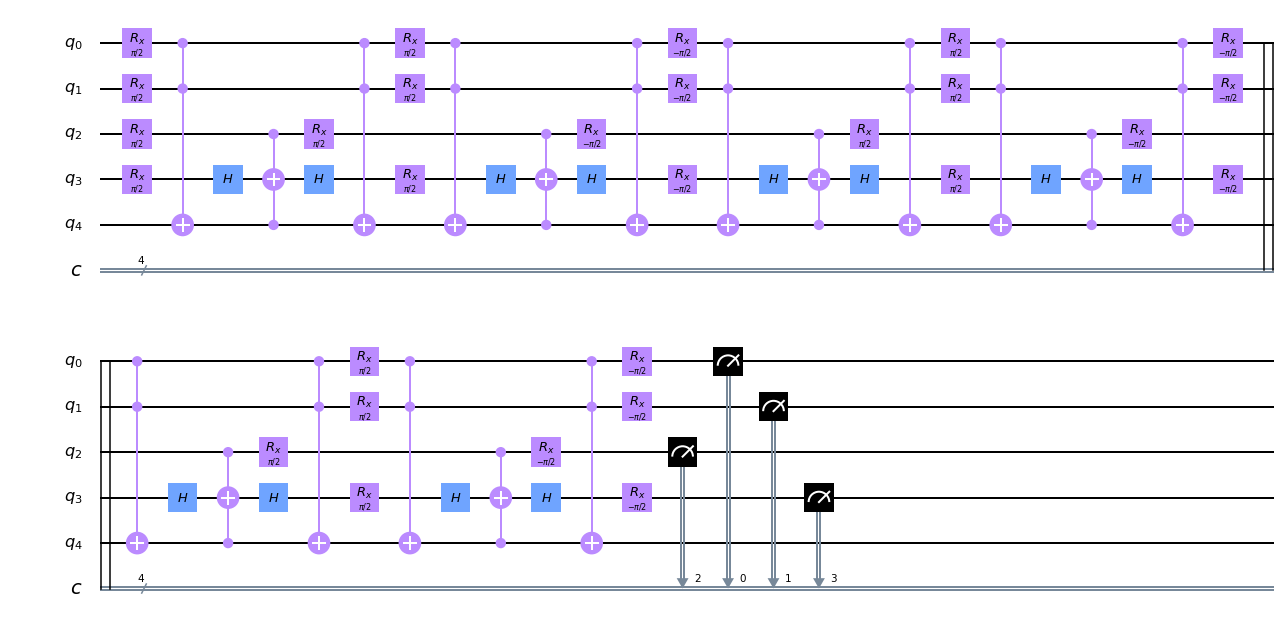

In [57]:
phase=grover(['1111'], 'ancilla',3)
print('Circuit width', phase.width() -4) # the method will compute the classical registers wires+the quantum ones,
                                        #the quantum registers are what matters us, this is why I subtract 4.
print('Count of operations', phase.count_ops())
phase.draw('mpl')

In [58]:
tranpile1= transpile(phase, device)
print('Phase circuit depth = ',tranpile1.depth())
print('Number of operations   ', tranpile1.count_ops())

Phase circuit depth =  336
Number of operations    OrderedDict([('cx', 305), ('u1', 113), ('u2', 42), ('measure', 4), ('barrier', 1)])


$\Rightarrow$ The $Circuit\;depth = 336$ and the $Quantum\;cost=305+113+42=460$

### 2-Boolean oracle Grover's circuit evaluation:

Circuit width 8
Count of operations OrderedDict([('ccx', 30), ('h', 30), ('x', 24), ('cx', 6), ('u2', 5), ('measure', 4), ('u3', 1)])


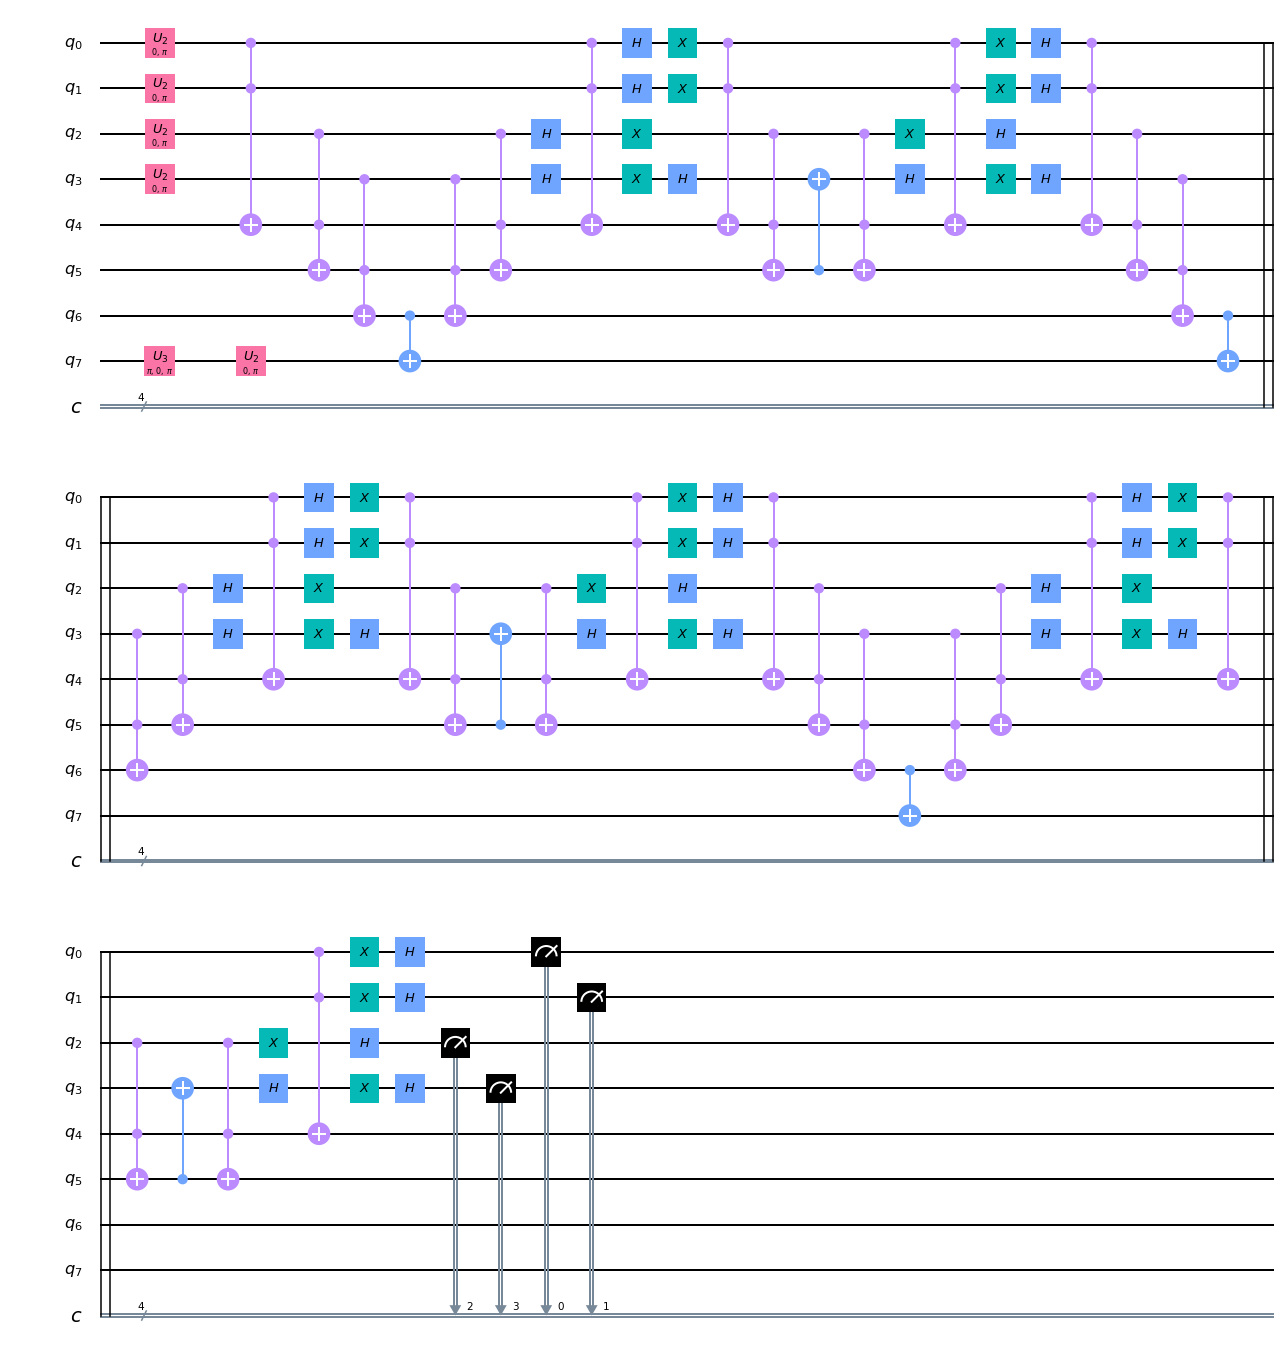

In [59]:
boolean=boolean_grover(['1111'], 'ancilla',3)
print('Circuit width', boolean.width() -4)
print('Count of operations', boolean.decompose().count_ops())
boolean.decompose().draw('mpl')

In [60]:
transpile2= transpile(boolean, device)
print('Boolean circuit depth = ',transpile2.depth())
print('Number of operation', transpile2.count_ops())

Boolean circuit depth =  588
Number of operation OrderedDict([('cx', 592), ('u1', 196), ('u2', 63), ('measure', 4), ('u3', 3), ('barrier', 1)])


$\Rightarrow$ The $Circuit\;depth = 588$ and the $Quantum\;cost=592+196+63+3=854$

Let's us calculate the difference between the two circuits:

$\Rightarrow$ The $Circuit\;depth\;diff = 588-336=252$, the $Quantum\;cost\;diff=854-460=394$ and the $Circuit\;width\;diff=8-5=3$

**The $Circuit\;depth\;diff$ and the $Quantum\;cost\;diff$ will grow up exponentially with the number of qubits, whereas the $Circuit\;width\;diff$ will be always different by 3 (2 for the case of three qubits) which means that we saved three qubits (two qubits for the case of three qubits) and reduces the number of gates**

## Test of the *Phase oracle + new design* Grover's circuit
I will do the test with the `ancilla` circuit because the major modification are done on it.

{'110': 7, '011': 966, '100': 4, '001': 7, '000': 11, '111': 8, '101': 9, '010': 12}


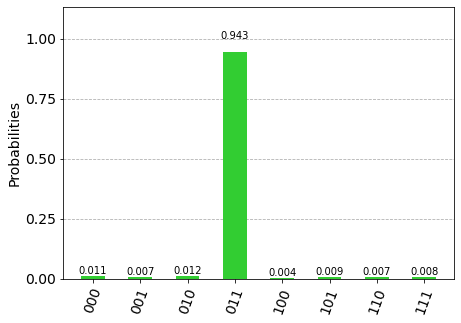

In [68]:
######################## three qubits test ########################
test1=grover(['011'],'ancilla',2)
count1 = execute(test1,simulator).result().get_counts()
print(count1)
plot_histogram(count1,color='limegreen')

{'111011': 1, '010000': 1, '010101': 1, '110010': 1020, '000001': 1}


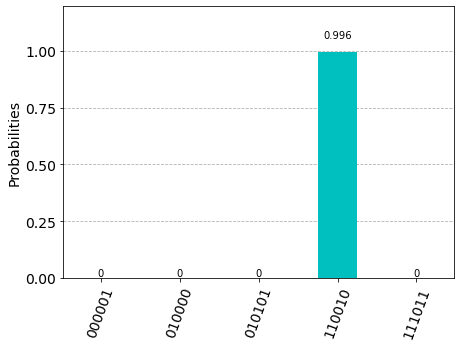

In [71]:
######################## Six qubits test ########################
test2=grover(['110010'],'ancilla',6)
count2 = execute(test2,simulator).result().get_counts()
print(count2)
plot_histogram(count2,color='c')

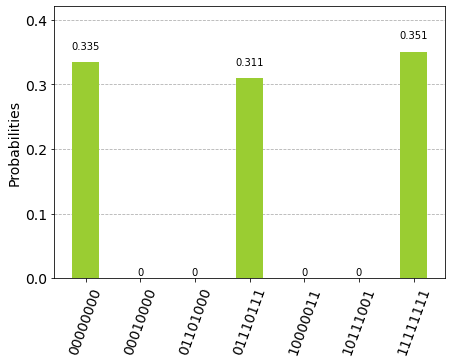

In [79]:
######################## eight qubits test with three solutions ########################
test3=grover(['11111111', '00000000','01110111'], 'ancilla', 7)
count3 = execute(test3,simulator).result().get_counts()
#print(count3)
plot_histogram(count3,color='yellowgreen')

<h1 align="center">
	References
</h1>
    
[1] [Gilliam, A., Pistoia, M., &amp; Gonciulea, C. (2020, May 26). Optimizing Quantum Search Using a Generalized Version of Grover's Algorithm.](https://arxiv.org/abs/2005.06468)